In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

d:\Anaconda\envs\TMenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-11 22:52:08,410	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cuda
Flower 1.19.0 / PyTorch 2.5.1+cu121


In [2]:
NUM_CLIENTS = 3
BATCH_SIZE = 256


def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\Duc Anh\.cache\huggingface\datasets\cifar10\plain_text\0.0.0\0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Fri Jul 11 10:27:12 2025).


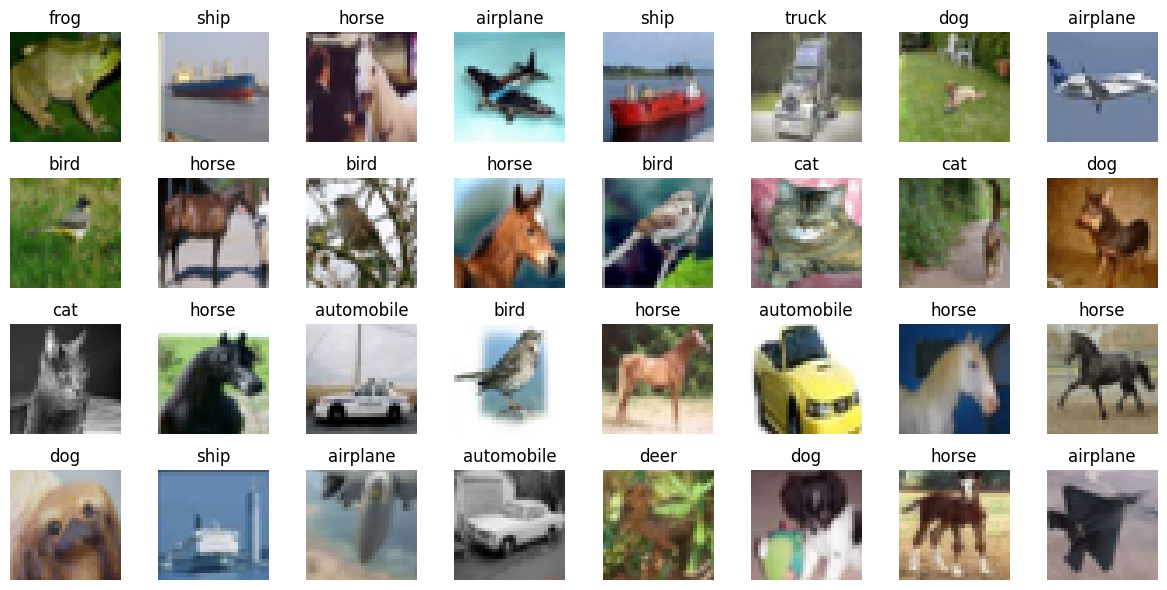

In [3]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # Calculate the size of the feature map after the last pooling layer
    # Input size: 32x32
    # After conv1 (5x5 kernel): 32 - 5 + 1 = 28
    # After pool (2x2 kernel, stride 2): 28 / 2 = 14
    # After conv2 (5x5 kernel): 14 - 5 + 1 = 10
    # After pool (2x2 kernel, stride 2): 10 / 2 = 5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [5]:
# test
net = Net()
net.to(DEVICE)

input = torch.rand(size = (1, 3, 32, 32), device = DEVICE)
output = net(input)
print(output.shape)

torch.Size([1, 10])


In [6]:
import logging

def train(net, trainloader, epochs : int, verbose : False):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters())

  # Remove logging configuration from here


  for epoch in range(epochs):
    epoch_loss, total, correct = 0.0, 0, 0
    for batch in trainloader:
      images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)

      pred = net(images)
      optimizer.zero_grad()
      loss = loss_fn(pred, labels)
      loss.backward()
      optimizer.step()

      # metric
      epoch_loss += loss
      total += len(labels)
      correct += (pred.argmax(1) == labels).float().sum()

    epoch_loss /= total
    epoch_acc = correct / total

    if verbose:
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.3f}, accuracy {epoch_acc:.3f}")

In [7]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [8]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [9]:
class FlowerClient(NumPyClient):
  def __init__(self, net, trainloader, valloader):
    self.net = net
    self.trainloader = trainloader
    self.valloader = valloader

  # return the current local model parameters
  def get_parameters(self, config):
    return get_parameters(self.net)

  # receive global parameter, train, return updated model to server
  def fit(self, parameters, config):
    set_parameters(self.net, parameters)
    train(self.net, self.trainloader, epochs = 1, verbose = False)

    return get_parameters(self.net), len(self.trainloader), {}

  # receive global parameter, evaluate model from local's data, return the evaluation result
  def evaluate(self, parameters, config):
    set_parameters(self.net, parameters)
    loss, acc = test(self.net, self.valloader)
    return float(loss), len(self.valloader), {"accuracy":float(acc)}

In [10]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [12]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

In [13]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=10756) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=10756) Found the latest cached dataset configuration 'plain_text' at C:\Users\Duc Anh\.cache\huggingface\datasets\cifar10\plain_text\0.0.0\0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Fri Jul 11 10:27:12 2025).
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
